In [1]:
import os

import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.backend.tensorflow_backend import set_session
import pandas as pd

tf.get_logger().setLevel('ERROR')

folder = "data/"
IMG_SIZE = 256

data = []
label = []

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3072)]
)

Using TensorFlow backend.


In [2]:
# 图片预处理函数
def load_preprosess_image(image_path, image_label):
    # 读取图片
    img_raw = tf.io.read_file(image_path)
    # 解码图片
    img_tensor = tf.image.decode_jpeg(img_raw, channels=3)
    # 统一图片大小
    img_tensor = tf.image.resize_with_pad(img_tensor, IMG_SIZE, IMG_SIZE)
    # 转换数据类型
    img_tensor = tf.cast(img_tensor, tf.float32)
    # 归一化
    img = img_tensor / 255

    return img, image_label


df = pd.read_csv(folder + 'cat_13_labels.txt', sep='\s+')
df = shuffle(df)
df['path'] = folder + df['path']
print(df.head())
path_ds = tf.data.Dataset.from_tensor_slices((df['path'], df['label']))
dataset = path_ds.map(load_preprosess_image)
print(dataset)

                                       path  label
1542  data/cat_13_dataset/Ragdoll000142.jpg      7
1340   data/cat_13_dataset/Orange000140.jpg      6
2134    data/cat_13_dataset/Tabby000134.jpg     10
2243       data/cat_13_dataset/TC000043.jpg     11
1546  data/cat_13_dataset/Ragdoll000146.jpg      7
<MapDataset shapes: ((256, 256, 3), ()), types: (tf.float32, tf.int32)>


In [3]:
#划分训练集和测试集
#测试个数取整
image_count = len(df)
test_count = int(image_count*0.2)
#训练个数
train_count = image_count - test_count
#训练数据集

print("train_count", train_count)
print("test_count", test_count)

train_dataset = dataset.skip(test_count)
#测试数据集
test_dataset = dataset.take(test_count)

batch_size = 64
#训练数据集重复,乱序,规定batch值
train_dataset = train_dataset.repeat().shuffle(buffer_size=train_count).batch(batch_size)
#测试数据集不做处理
test_dataset = test_dataset.batch(batch_size)

train_count 2080
test_count 520


In [4]:
#建立模型
#使用VGG16迁移学习
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
covn_base = tf.keras.applications.VGG16(input_shape=IMG_SHAPE, weights='imagenet',include_top=False)
model = tf.keras.Sequential()
model.add(covn_base)
#全局平均值化 降维 dropout
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(13, activation='softmax'))
#模型摘要
model.summary()
#训练模型
#预训练网络权重不被训练
covn_base.trainable = False
#没自定义训练,均默认
#配置优化器,损失函数,显示准确率
opt = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.001, amsgrad=False)
model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 13)                6669      
Total params: 14,984,013
Trainable params: 14,984,013
Non-trainable params: 0
_________________________________________________________________


Train for 32 steps, validate for 8 steps
Epoch 1/150
32/32 [==============================] - 41s 1s/step - loss: 2.5465 - acc: 0.1299 - val_loss: 2.5301 - val_acc: 0.1582
Epoch 2/150
32/32 [==============================] - 25s 775ms/step - loss: 2.4967 - acc: 0.2114 - val_loss: 2.4745 - val_acc: 0.2188
Epoch 3/150
32/32 [==============================] - 25s 776ms/step - loss: 2.4441 - acc: 0.2822 - val_loss: 2.4352 - val_acc: 0.2773
Epoch 4/150
32/32 [==============================] - 25s 772ms/step - loss: 2.3964 - acc: 0.3330 - val_loss: 2.3915 - val_acc: 0.3672
Epoch 5/150
32/32 [==============================] - 25s 775ms/step - loss: 2.3561 - acc: 0.3970 - val_loss: 2.3469 - val_acc: 0.4062
Epoch 6/150
32/32 [==============================] - 25s 772ms/step - loss: 2.2976 - acc: 0.4604 - val_loss: 2.3083 - val_acc: 0.4531
Epoch 7/150
32/32 [==============================] - 25s 775ms/step - loss: 2.2662 - acc: 0.4849 - val_loss: 2.2858 - val_acc: 0.4707
Epoch 8/150
32/32 [=====

32/32 [==============================] - 23s 728ms/step - loss: 1.9472 - acc: 0.7734 - val_loss: 2.0255 - val_acc: 0.6934
Epoch 62/150
32/32 [==============================] - 25s 775ms/step - loss: 1.9497 - acc: 0.7700 - val_loss: 2.0222 - val_acc: 0.6992
Epoch 63/150
32/32 [==============================] - 25s 776ms/step - loss: 1.9588 - acc: 0.7622 - val_loss: 2.0232 - val_acc: 0.7031
Epoch 64/150
32/32 [==============================] - 23s 729ms/step - loss: 1.9538 - acc: 0.7632 - val_loss: 2.0276 - val_acc: 0.6953
Epoch 65/150
32/32 [==============================] - 23s 729ms/step - loss: 1.9569 - acc: 0.7583 - val_loss: 2.0242 - val_acc: 0.6992
Epoch 66/150
32/32 [==============================] - 23s 729ms/step - loss: 1.9536 - acc: 0.7617 - val_loss: 2.0193 - val_acc: 0.6992
Epoch 67/150
32/32 [==============================] - 23s 729ms/step - loss: 1.9441 - acc: 0.7769 - val_loss: 2.0181 - val_acc: 0.6973
Epoch 68/150
32/32 [==============================] - 23s 729ms/step

32/32 [==============================] - 23s 729ms/step - loss: 1.8499 - acc: 0.8862 - val_loss: 1.9502 - val_acc: 0.7793
Epoch 122/150
32/32 [==============================] - 25s 777ms/step - loss: 1.8410 - acc: 0.8994 - val_loss: 1.9444 - val_acc: 0.7891
Epoch 123/150
32/32 [==============================] - 25s 774ms/step - loss: 1.8487 - acc: 0.8838 - val_loss: 1.9466 - val_acc: 0.7930
Epoch 124/150
32/32 [==============================] - 23s 729ms/step - loss: 1.8434 - acc: 0.8882 - val_loss: 1.9457 - val_acc: 0.7891
Epoch 125/150
32/32 [==============================] - 25s 777ms/step - loss: 1.8516 - acc: 0.8838 - val_loss: 1.9440 - val_acc: 0.7949
Epoch 126/150
32/32 [==============================] - 25s 775ms/step - loss: 1.8440 - acc: 0.8882 - val_loss: 1.9397 - val_acc: 0.7969
Epoch 127/150
32/32 [==============================] - 25s 776ms/step - loss: 1.8375 - acc: 0.8931 - val_loss: 1.9427 - val_acc: 0.7988
Epoch 128/150
32/32 [==============================] - 23s 729

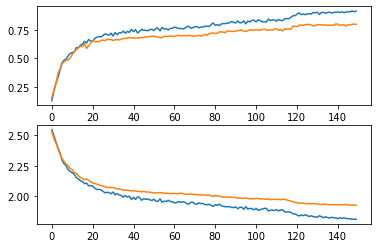

In [5]:
#步长
steps_per_epoch = train_count//batch_size
validation_steps = test_count//batch_size

checkpointer = tf.keras.callbacks.ModelCheckpoint('model', monitor='val_acc', verbose=0,save_best_only=True,save_weights_only=False, mode='auto',save_freq='epoch')

#记录数据
history = model.fit(train_dataset, epochs=150, steps_per_epoch=steps_per_epoch,validation_data=test_dataset,validation_steps=validation_steps, callbacks=[checkpointer])


#调用参数,绘制图型
plt.subplot(211)
plt.plot(history.epoch,history.history['acc'])
plt.plot(history.epoch,history.history['val_acc'])
plt.subplot(212)
plt.plot(history.epoch,history.history.get('loss'))
plt.plot(history.epoch,history.history.get('val_loss'))
plt.show()